<a href="https://colab.research.google.com/github/AntoineHocquet/DS-assignment/blob/main/Semantic_Edge_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project Title: **Semantic Edge Detection**
## By *Antoine Hocquet*
### Interview Preparation for **Picsart**
#### (Date: 14.03.2025)


# Preliminaries



This notebook contains the answers to questions 1 to 7 from the problem sheet 'Task_CV_Edge_Detection.pdf'.

The models have already been trained and saved within my Google Drive. These are joined to the Notebook for convenience.

For readability, these are named by following the convention `model1` for Task 1, `model2` for Task 2, and so on. Similar notations for variable names are used all throughout (e.g. for data-loaders or classes).

**Dataset:**

This notebook assumes that you have a local version of the `DAVIS-2017-trainval` dataset, which is the one I chose to work with on DAVIS' website.

More precisely, by going at the URL
[https://davischallenge.org/davis2017/code.html](https://davischallenge.org/davis2017/code.html)
, you can download this data set with filename
`DAVIS-2017-trainval-480p.zip`.

You need to unzip this file: below, there is an additional step for doing that directly inside the notebook (of course you can skip this step if you have a better way to unzip this file).




## Required libraries for this notebook

In [ ]:
# We import all the API needed in the notebook
!pip install torchinfo

# File access
from google.colab import drive # to access dataset
import zipfile # to unzip dataset
import os # for file operations

# Basic Python
import random
import numpy as np
import matplotlib.pyplot as plt

# Computer vision
import cv2
from skimage import io, filters # to detect edges in annotations
from PIL import Image

# Pytorch APIs
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, Subset
import torch.nn.functional as F
import torch.optim as optim
from torchinfo import summary # for schematic overview of nn


## Data access

Access Google Drive where dataset `DAVIS-2017-trainval-480p` is located

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


Main paths for file access

In [ ]:
zip_path = "/content/drive/MyDrive/interview/DAVIS-2017-trainval-480p.zip"  # path of zip file
extract_path = "/content/drive/MyDrive/interview/DAVIS-2017-trainval-480p"  # path of extracted data
save_path = '/content/drive/MyDrive' # path to save models

List containing all video names

In [ ]:
video_names = os.listdir(extract_path + "/DAVIS/JPEGImages/480p")
print(video_names)

['bear', 'bike-packing', 'blackswan', 'bmx-bumps', 'bmx-trees', 'boat', 'boxing-fisheye', 'breakdance', 'breakdance-flare', 'bus', 'camel', 'car-roundabout', 'car-shadow', 'car-turn', 'cat-girl', 'classic-car', 'color-run', 'cows', 'crossing', 'dance-jump', 'dance-twirl', 'dancing', 'disc-jockey', 'dog', 'dog-agility', 'dog-gooses', 'dogs-jump', 'dogs-scale', 'drift-chicane', 'drift-straight', 'drift-turn', 'drone', 'elephant', 'flamingo', 'goat', 'gold-fish', 'hike', 'hockey', 'horsejump-high', 'horsejump-low', 'india', 'judo', 'kid-football', 'kite-surf', 'kite-walk', 'koala', 'lab-coat', 'lady-running', 'libby', 'lindy-hop', 'loading', 'longboard', 'lucia', 'mallard-fly', 'mallard-water', 'mbike-trick', 'miami-surf', 'motocross-bumps', 'motocross-jump', 'motorbike', 'night-race', 'paragliding', 'paragliding-launch', 'parkour', 'pigs', 'planes-water', 'rallye', 'rhino', 'rollerblade', 'schoolgirls', 'scooter-black', 'scooter-board', 'scooter-gray', 'sheep', 'shooting', 'skate-park', 

Unzip data (might take 15min). Only necessary for first use.

In [ ]:
# # UNCOMMENT IF NECESSARY
# with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#     zip_ref.extractall(extract_path)

# print("Extraction done!")

## Frequently used macros

### Python functions

In [ ]:
def pick_video(extract_path = extract_path, name=None):
    """
    Inputs:
    - extract_path: path where dataset is unzipped
    - name: a video name in the directory list
    Picks a video at random unless a specific name is given
    Returns the video name, path to frames, and path to annotations.
    """
    if name is None:
        video_names = os.listdir(extract_path + "/DAVIS/JPEGImages/480p")
        video_name = random.choice(video_names)
    else:
        video_name = name
    video_path = extract_path + f"/DAVIS/JPEGImages/480p/{video_name}"
    annotation_path = extract_path + f"/DAVIS/Annotations/480p/{video_name}"
    print("The newly chosen video is:", video_name)

    return video_name, video_path, annotation_path


def tensor_describe(tensor):
    """
    Prints the shape, mean, std, min, and max of a PyTorch tensor.
    """
    print("Tensor Shape:", tensor.shape)
    print("Mean:", tensor.mean().item())
    print("Std:", tensor.std().item())
    print("Min:", tensor.min().item())
    print("Max:", tensor.max().item())
    print("-"*75)


# MIN MAX NORMALIZATION FOR NUMPY ARRAY
def normalize_min_max_numpy(x):
    """
    Normalizes a NumPy array to the range [0, 1] using min-max normalization.
    """
    return (x - x.min()) / (x.max() - x.min())

# 3 sided plots for model evaluation
def side_comparison(original_image, ground_truth, model_prediction):
    """
    Plots three images side by side: original image, ground truth, and model prediction.
    Input:
    - original_image: Pytorch tensor of shape [1,3,256,256]
    - ground_truth: Pytorch tensor of shape [1,1,256,256]
    - model_prediction: Pytorch tensor of shape [1,1,256,256]
    """
    # Create a figure with 3 subplots
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))

    # Plot Original Image
    image_np = original_image.squeeze(0).permute(1, 2, 0).cpu().numpy()
    ax[0].imshow(image_np)
    ax[0].set_title("Original Image")
    ax[0].axis("off")

    # Plot Ground Truth (Annotation)
    ground_truth_np = ground_truth.squeeze(0).permute(1, 2, 0).cpu().numpy()
    ax[1].imshow(ground_truth_np, cmap="gray")
    ax[1].set_title("Ground Truth Edge Map")
    ax[1].axis("off")

    # Plot Model's Predicted Edge Map
    output_np = model_prediction.squeeze(0).permute(1, 2, 0).cpu().numpy()
    ax[2].imshow(output_np, cmap="gray")
    ax[2].set_title("Predicted Edge Map (Trained Model)")
    ax[2].axis("off")

    plt.tight_layout()
    plt.show()

### Transforms


In [ ]:
# PYTORCH TRANSFORMS
# min-max normalization
normalize_min_max = transforms.Lambda(lambda x: (x - x.min()) / (x.max() - x.min()))

# Resize to 256 x 256 and apply standard normalization (RGB)
resize_normalize = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    normalize_min_max
])


### `DAVISDataset` Pytorch Dataset

Creating a *PyTorch Dataset* for easy loading of Video Frames and edges (masks)

**Rem**:
- videos are collections of *.JPG files* labelled as `'00000.jpg'`, `'00001.jpg'`, etc.
- annotations are *.PNG files*, labelled correspondingly as `'00000.png'`, `'00001.png'` and so on.

In [ ]:
class DAVISDataset(Dataset):
    """
    Custom PyTorch Dataset for DAVIS frames and edge masks.
    Attributes:
    - image_dir: Path to frames
    - mask_dir: Path to edge masks
    - transform: Transformations for both image & mask
    """
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir  # Path to frames
        self.mask_dir = mask_dir    # Path to edge masks
        self.transform = transform  # Transformations for both image & mask

        # List all frame filenames (assume they match between images & masks)
        self.image_filenames = sorted(os.listdir(image_dir))

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        img_name = self.image_filenames[idx]

        # Load image
        img_path = os.path.join(self.image_dir, img_name)
        image = Image.open(img_path).convert("RGB")

        # Load corresponding mask
        mask_path = os.path.join(self.mask_dir, img_name.replace(".jpg", ".png"))  # Assuming PNG format for masks
        mask = Image.open(mask_path).convert("L")  # Convert to grayscale

        # Apply transformations
        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)  # Apply same transformations to both

        return image, mask  # Return both image and mask tensors

# dummy test
video_name = "bear"
_, video_path, annotation_path = pick_video(name=video_name)
dataset= DAVISDataset(image_dir = video_path, mask_dir = annotation_path, transform = resize_normalize)
image, mask = dataset[0]
print("Image shape:", image.shape)
print("Mask shape:", mask.shape)

The newly chosen video is: bear
Image shape: torch.Size([3, 256, 256])
Mask shape: torch.Size([1, 256, 256])


### Training setup

In [ ]:
# Training setup (for tasks 1 to 4)

def train_model(model, dataset, batch_size, loss, epochs=5, lr=1e-3):
    """
    Train the model on the given dataset.

    Parameters:
    - model: PyTorch model
    - dataset: PyTorch dataset
    - batch_size: Batch size for training
    - loss: Loss function
    - epochs: Number of training epochs
    - lr: Learning rate

    Returns:
    - model: Trained PyTorch model
    """
    optimizer = optim.Adam(model.parameters(), lr=lr)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    n = epochs//10 if (epochs//10 != 0) else 1 # avoid division by 0

    losses = []

    model.train() # set model to training mode

    for epoch in range(epochs):
        model.train() # set model to training mode
        epoch_loss = 0.0

        for images, masks in dataloader:
            images, masks = images.to(device), masks.to(device)

            optimizer.zero_grad()
            outputs = model(images) # forward pass

            loss_value = loss(outputs, masks) # compute loss
            loss_value.backward() # backpropagation
            optimizer.step() # update weights

            epoch_loss += loss_value.item()

        losses.append(epoch_loss)

        if (epoch+1) % n == 0:
            print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss/len(dataloader):.4f}")

    plt.plot(losses)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training Loss Curve")
    plt.show()

    return model

# Task 1: Choose video

**Instructions:** Choose a video from the DAVIS dataset, get its frames, and obtain the edges of the frames from the annotations of these frames. *Present them*.

**Rem:** reading an image with `io.imread()` gives:
- a nested Numpy array (not a tensor, strictly speaking)
- shape (3, 480, 854) (order is permuted).

## Pick video at random and process it

**Rem**:
- the video is chosen (randomly);
- we plot the `5`th image of the video, jointly with the edge.

In [ ]:
# Pick video randomly
video_name1, video_path1, annotation_path1 = pick_video()
dataset1= DAVISDataset(image_dir = video_path1, mask_dir = annotation_path1, transform = resize_normalize)
dataloader1 = DataLoader(dataset1, batch_size=1, shuffle=False)

# get the nth pair (image, edge): [1,3,256,256], [1,1,256,256]
n=5
dataloader_iter1 = iter(dataloader1)  # Create an iterator
for i in range(n):  # Skip the first (n-1) batches
    next(dataloader_iter1)
image_n, edge_n = next(dataloader_iter1)

tensor_describe(image_n)
tensor_describe(edge_n)


The newly chosen video is: india
Tensor Shape: torch.Size([1, 3, 256, 256])
Mean: 0.34078657627105713
Std: 0.2436220794916153
Min: 0.0
Max: 1.0
---------------------------------------------------------------------------
Tensor Shape: torch.Size([1, 1, 256, 256])
Mean: 0.13347429037094116
Std: 0.28369614481925964
Min: 0.0
Max: 1.0
---------------------------------------------------------------------------


## Display Frames and Edges side by side.


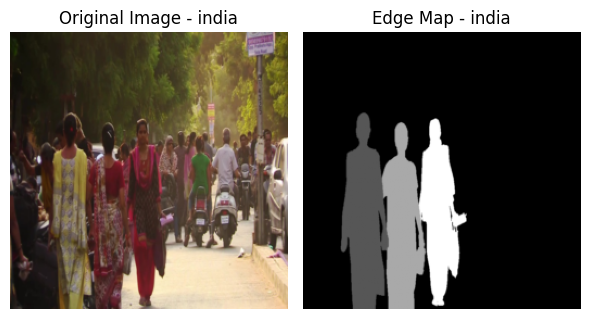

In [ ]:
# convert fully processed tensors to numpy arrays for visualization
image_n_np = image_n.squeeze(0).permute(1, 2, 0).cpu().numpy()
edge_n_np = edge_n.squeeze(0).permute(1, 2, 0).cpu().numpy()

fig, axes = plt.subplots(1, 2, figsize=(6, 6))

axes[0].imshow(image_n_np)
axes[0].set_title(f"Original Image - {video_name1}")
axes[0].axis("off")

axes[1].imshow(edge_n_np, cmap="gray")
axes[1].set_title(f"Edge Map - {video_name1}")
axes[1].axis("off")

plt.tight_layout()

**Rem:** annotations are not binary as such: they need to be processed to reduce channels from 3 to 1 (grayscale).

# **Task 2**: building the first Encoder-Decoder architecture

**Instructions:** Build an Encoder-Decoder architecture to train a neural network for semantic edge detection on a single image. Take as an encoder one of the `ResNet` (18, 50, or 101) architectures and initialize it with pre-trained weights.

**Rem**:
In this notebook, we chose to work with `ResNet18`

## Pick first image


We choose the first image `'00000.png'` from the randomly chosen video above.

Unlike for training, we plot it without process (just for visualization).

In [ ]:
# ENCODER
# We use pretrained ResNest18
class Encoder2(nn.Module):
    def __init__(self, pretrained=True):
        super(Encoder2, self).__init__()

        # Load ResNet18
        resnet = models.resnet18(pretrained=pretrained)

        # Remove the fully connected layers to keep it convolutional
        # Select layers to extract features for skip connections
        self.encoder = nn.Sequential(*list(resnet.children())[:-2])
        #self.features = []  # initialize to empty list #MODIFIED

        # register forward hooks to capture features maps from desired layers
        # Capture from layer1, layer2, layer3, and layer4
        # This will give us 4 skip connections as expected by the decoder
        # resnet.layer1.register_forward_hook(self.save_features) #MODIFIED
        # resnet.layer2.register_forward_hook(self.save_features) #MODIFIED
        # resnet.layer3.register_forward_hook(self.save_features) #MODIFIED
        # resnet.layer4.register_forward_hook(self.save_features) #MODIFIED
        self.layer1 = resnet.layer1
        self.layer2 = resnet.layer2
        self.layer3 = resnet.layer3
        self.layer4 = resnet.layer4


    # Define hook function to save features
    # def save_features(self, module, input, output): #MODIFIED
    #    self.features.append(output)  #MODIFIED

    def forward(self, x):
        #_ = self.encoder(x)  # execute forward to trigger hooks #MODIFIED
        x = self.encoder[0](x) # conv1
        x = self.encoder[1](x) # bn1
        x = self.encoder[2](x) # relu
        x = self.encoder[3](x) # maxpool
        # Save outputs from desired layers: layer1, layer2, layer3, layer4
        encoder_features = []
        x = layer_out1 = self.layer1(x) # layer1
        encoder_features.append(layer_out1) # Save output from layer1
        x = layer_out2 = self.layer2(x) # layer2
        encoder_features.append(layer_out2) # Save output from layer2
        x = layer_out3 = self.layer3(x) # layer3
        encoder_features.append(layer_out3) # Save output from layer3
        x = layer_out4 = self.layer4(x) # layer4
        encoder_features.append(layer_out4) # Save output from layer4

        # Reverse the list to match order with original code
        # encoder_features = self.features[::-1] #MODIFIED
        #self.features = []  # clear list before next call #MODIFIED
        return encoder_features, encoder_features[-1]  # return encoder_features and bottleneck


# DECODER
class Decoder2(nn.Module):
    def __init__(self, encoder_channels=[512, 256, 128, 64], out_channels=1):
        super(Decoder2, self).__init__()

                # Upsampling with Bilinear + Conv (Solution 1)
        self.up1 = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.Conv2d(encoder_channels[0], 256, kernel_size=3, padding=1),
            nn.ReLU()
        )
        self.up2 = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.Conv2d(256 + encoder_channels[1], 128, kernel_size=3, padding=1),  # Skip connection
            nn.ReLU()
        )
        self.up3 = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.Conv2d(128 + encoder_channels[2], 64, kernel_size=3, padding=1),  # Skip connection
            nn.ReLU()
        )
        self.up4 = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.Conv2d(64 + encoder_channels[3], 32, kernel_size=3, padding=1),  # Skip connection
            nn.ReLU()
        )
        self.final_conv = nn.Conv2d(32, out_channels, kernel_size=1)  # 1x1 Conv for final mask

    def forward(self, x, encoder_features):
        x = self.up1(x)
        x = torch.cat([x, encoder_features[3]], dim=1)  # Skip connection
        x = self.up2(x)
        x = torch.cat([x, encoder_features[2]], dim=1)  # Skip connection
        x = self.up3(x)
        x = torch.cat([x, encoder_features[1]], dim=1)  # Skip connection
        x = self.up4(x)
        x = torch.cat([x, encoder_features[0]], dim=1)  # Skip connection
        x = self.final_conv(x)
        return torch.sigmoid(x)  # Final probability map


# COMBINE
class EdgeDetectionModel2(nn.Module):
    def __init__(self, pretrained=True):
        super(EdgeDetectionModel2, self).__init__()
        self.encoder = Encoder2(pretrained=pretrained)  # ResNet18 backbone
        self.pinch = nn.SiLU()  # Apply Swish at the bottleneck
        self.decoder = Decoder2()

    def forward(self, x):
        # Store intermediate feature maps from the encoder
        encoder_features = []
        for layer in self.encoder.children():
            x = layer(x)
            encoder_features.append(x)

        bottleneck = self.pinch(encoder_features[-1])  # Apply non-linearity at bottleneck
        output = self.decoder(bottleneck, encoder_features[:-1])  # Pass skip connections
        return output


# We can load a dummy instance of model here to visualize its layers.
model_dummy= EdgeDetectionModel2(pretrained=False)
summary(model_dummy, input_size=(1, 3, 256, 256))

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


RuntimeError: Failed to run torchinfo. See above stack traces for more details. Executed layers up to: [Sequential: 2, Conv2d: 3, BatchNorm2d: 3, ReLU: 3, MaxPool2d: 3, Sequential: 2, BasicBlock: 3, Conv2d: 4, BatchNorm2d: 4, ReLU: 4, Conv2d: 4, BatchNorm2d: 4, ReLU: 4, BasicBlock: 3, Conv2d: 4, BatchNorm2d: 4, ReLU: 4, Conv2d: 4, BatchNorm2d: 4, ReLU: 4, Sequential: 2, BasicBlock: 3, Conv2d: 4, BatchNorm2d: 4, ReLU: 4, Conv2d: 4, BatchNorm2d: 4, Sequential: 4, Conv2d: 5, BatchNorm2d: 5, ReLU: 4, BasicBlock: 3, Conv2d: 4, BatchNorm2d: 4, ReLU: 4, Conv2d: 4, BatchNorm2d: 4, ReLU: 4, Sequential: 2, BasicBlock: 3, Conv2d: 4, BatchNorm2d: 4, ReLU: 4, Conv2d: 4, BatchNorm2d: 4, Sequential: 4, Conv2d: 5, BatchNorm2d: 5, ReLU: 4, BasicBlock: 3, Conv2d: 4, BatchNorm2d: 4, ReLU: 4, Conv2d: 4, BatchNorm2d: 4, ReLU: 4, Sequential: 2, BasicBlock: 3, Conv2d: 4, BatchNorm2d: 4, ReLU: 4, Conv2d: 4, BatchNorm2d: 4, Sequential: 4, Conv2d: 5, BatchNorm2d: 5, ReLU: 4, BasicBlock: 3, Conv2d: 4, BatchNorm2d: 4, ReLU: 4, Conv2d: 4, BatchNorm2d: 4, ReLU: 4]

## Overfit on a selected Image

'Sanity check': check if the network can at least memorize the mapping between input image and edge.

The newly chosen video is: cat-girl
Image shape: torch.Size([1, 3, 256, 256])
Mask shape: torch.Size([1, 1, 256, 256])


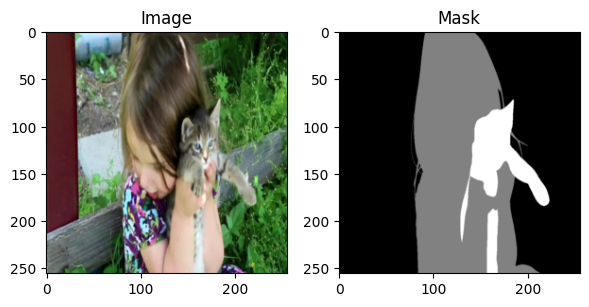

In [ ]:
# dummy test
video_name = "cat-girl"
_, video_path, annotation_path = pick_video(name=video_name)

# Creates dataloader with only one pair (image,mask)
dataset= DAVISDataset(image_dir = video_path, mask_dir = annotation_path, transform = resize_normalize)
dataset2 = Subset(dataset, [40])
dataloader2 = DataLoader(dataset2, batch_size=1, shuffle=False)

# Extracts the pair (simply for visualization)
image, mask = next(iter(dataloader2))
print("Image shape:", image.shape)
print("Mask shape:", mask.shape)

#plot image and mask
fig, axes = plt.subplots(1, 2, figsize=(6,8))
axes[0].imshow(image[0].permute(1,2,0))
axes[0].set_title("Image")
axes[1].imshow(mask[0].permute(1,2,0), cmap='gray')
axes[1].set_title("Mask")

plt.tight_layout()
plt.show()

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 126MB/s]


Epoch 10/100, Loss: 0.8028
Epoch 20/100, Loss: 0.6868
Epoch 30/100, Loss: 0.6858
Epoch 40/100, Loss: 0.6850
Epoch 50/100, Loss: 0.6840
Epoch 60/100, Loss: 0.6836
Epoch 70/100, Loss: 0.6834
Epoch 80/100, Loss: 0.6832
Epoch 90/100, Loss: 0.6830
Epoch 100/100, Loss: 0.6824


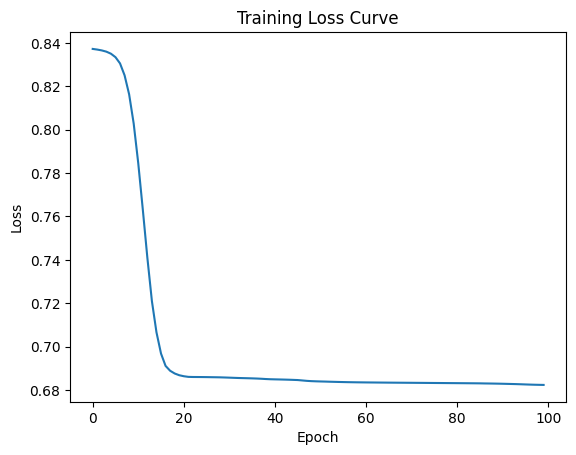

In [ ]:
# Initialize 'model2'
model2 = EdgeDetectionModel2(pretrained=True)

# define the loss function (Binary Cross-Entropy loss)
loss_fn = torch.nn.BCEWithLogitsLoss()

# set epochs
num_epochs = 100  #1000 -> Overfitting to confirm learning

# train model on the first image only
train_model(model2, dataset=dataset2, batch_size=4, loss=loss_fn, epochs=num_epochs)

# SAVING THE MODEL AFTER TRAINING
torch.save(model2.state_dict(), save_path + '/model2.pth')

Load here if needed

In [ ]:
# LOADING
model2 = EdgeDetectionModel2(pretrained=False)
model2.load_state_dict(torch.load(save_path + '/model2.pth'))

<ipython-input-18-73f91a03d99f>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model2.load_state_dict(torch.load(save_path + '/model2.pth'))


<All keys matched successfully>

Run inference on the trained model for sanity check:
- process output for vizualization
- plot original image, ground truth, and model prediction

Original image
Tensor Shape: torch.Size([1, 3, 256, 256])
Mean: 0.38130679726600647
Std: 0.23816221952438354
Min: 0.0
Max: 1.0
---------------------------------------------------------------------------
Ground truth
Tensor Shape: torch.Size([1, 1, 256, 256])
Mean: 0.23280619084835052
Std: 0.3140875995159149
Min: 0.0
Max: 1.0
---------------------------------------------------------------------------
Model prediction
Tensor Shape: torch.Size([1, 1, 256, 256])
Mean: 0.10671290010213852
Std: 0.29345178604125977
Min: 0.0
Max: 1.0
---------------------------------------------------------------------------


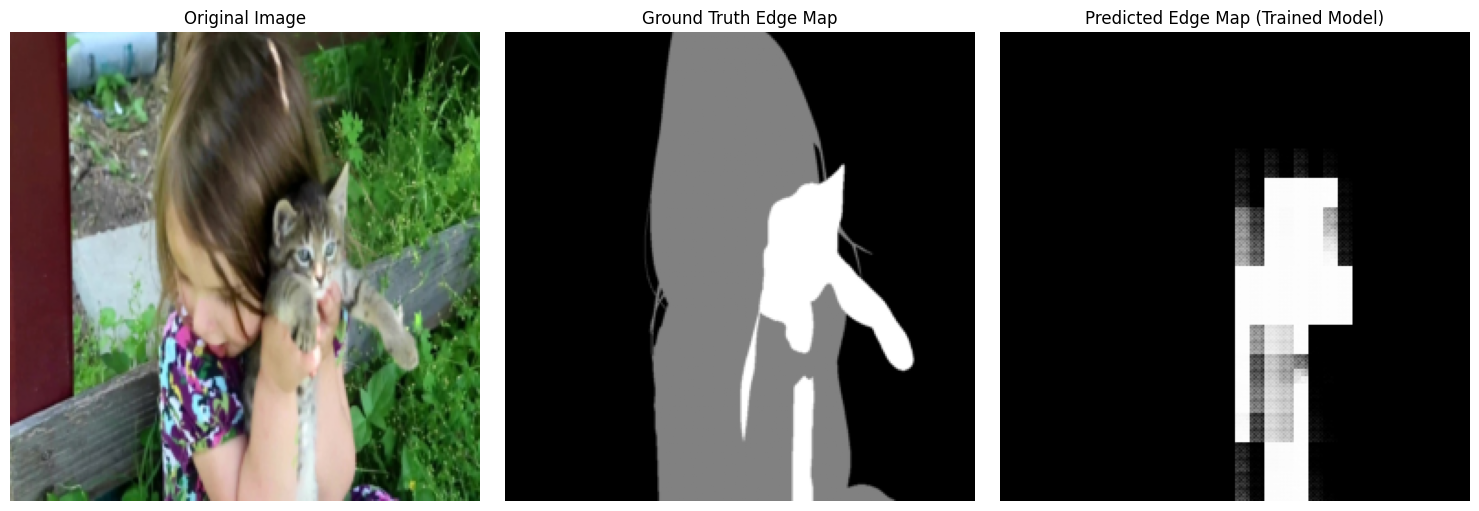

In [ ]:
model2.eval()  # Set model to evaluation mode

original_image, ground_truth = list(dataloader2)[0] # Get a single frame

print("Original image")
tensor_describe(original_image)
print("Ground truth")
tensor_describe(ground_truth)

with torch.no_grad():  # No need to compute gradients during inference
    model_prediction = model2(original_image)  # Get prediction
print("Model prediction")
tensor_describe(normalize_min_max(model_prediction))


# Create a figure with 3 subplots
side_comparison(original_image[0], ground_truth[0].unsqueeze(0), normalize_min_max(model_prediction[0]).unsqueeze(0))

**Observation:** the model has learned (somewhat). We can proceed further and overfit on a video.

# **Task 3**: overfit on a video

**Instructions**: Define a loss function, and overfit the model with it on the chosen video's frames. Show the results of overfitting.

## Training loop for multiple frames

We modify our previous training loop from *Task 2* to train on multiple images. More precisely:
- we use the same architecture as before (`EdgeDetectionModel2`);
- we call a new instance `'model3'` (for *Task 3*);
- we then train `model3` on the full video.



The newly chosen video is: bear
Epoch 1/5, Loss: 0.8366
Epoch 2/5, Loss: 0.6789
Epoch 3/5, Loss: 0.6785
Epoch 4/5, Loss: 0.6777
Epoch 5/5, Loss: 0.6773


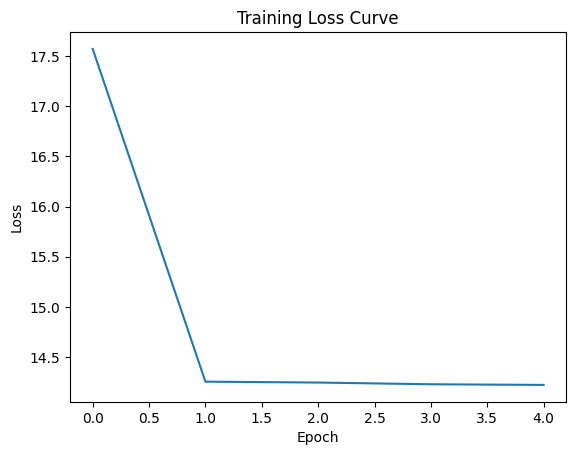

In [ ]:
# Define new video and new paths
video_name3, video_path3, annotation_path3 = pick_video(name="bear")

# reinitialize model
# use the 'EdgeDetectionModel2' architecture from Task 2 with pretrained weights
model3 = EdgeDetectionModel2()
dataset3 = DAVISDataset(image_dir = video_path3, mask_dir = annotation_path3, transform = resize_normalize)
num_epochs = 5
batch_size = 4
loss_fn = torch.nn.BCEWithLogitsLoss()

train_model(model3, dataset=dataset3, batch_size=batch_size, loss=loss_fn, epochs=num_epochs)

# SAVING THE MODEL ONCE TRAINED
torch.save(model3.state_dict(), save_path + '/model3.pth')

Test: run inference on a validation image

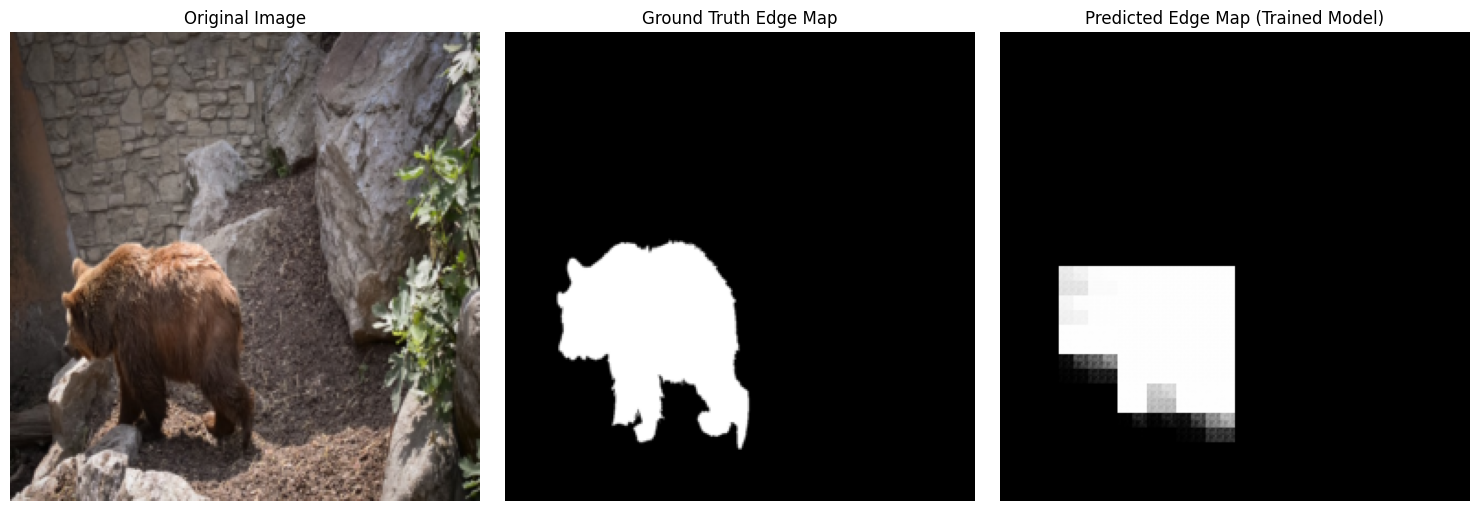

In [ ]:
model3 = EdgeDetectionModel2()
model3.load_state_dict(torch.load(save_path + '/model3.pth'))
model3.eval();

with torch.no_grad():
    # random integer between min and max arg
    N = random.randint(0, len(dataset3)-1)
    test_image, test_mask = dataset3[N]  # Pick a random test frame
    test_image = test_image.unsqueeze(0)  # Add batch dimension
    pred_mask = model3(test_image)  # Predict edge mask


# Plot results
side_comparison(test_image[0], test_mask.unsqueeze(0), normalize_min_max(pred_mask[0]).unsqueeze(0))

## Result of overfitting

Let us try an inference on a different video and visualize it.


We first re-run training on model 3 to ensure overfitting.

Epoch 1/6, Loss: 0.6770
Epoch 2/6, Loss: 0.6770
Epoch 3/6, Loss: 0.6769
Epoch 4/6, Loss: 0.6769
Epoch 5/6, Loss: 0.6769
Epoch 6/6, Loss: 0.6769


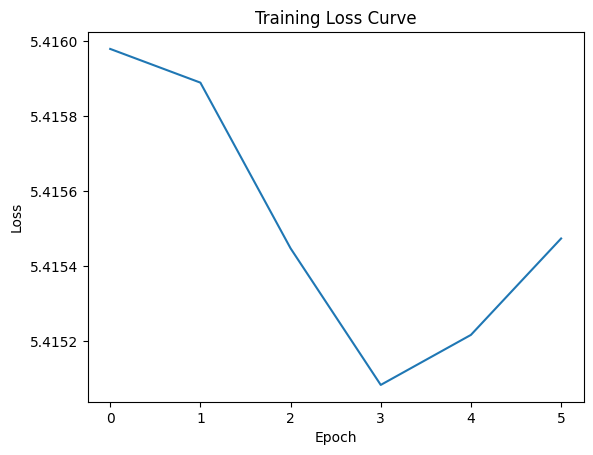


 Achieved re-training over 6


In [ ]:
## RE-RUN THE CELL TO CREATE MORE OVERFIT
# We first re-load our model
model3 = EdgeDetectionModel2()
model3.load_state_dict(torch.load(save_path + '/model3.pth'))

# We set new hyperparameters, but keep the same loss function
epochs=5
lr=0.00001
batch_size=11
epochs =6

# retrain the loaded model to ensure overfit
train_model(model3, dataset=dataset3, batch_size=batch_size, loss=loss_fn, epochs=epochs, lr=lr)
print(f"\n Achieved re-training over {epochs} epochs")

# save
torch.save(model3.state_dict(), save_path + '/model3.pth')

Observations:
- the learning curve has started to stabilize
- progress has become noisy.

This indicates overfit.

The newly chosen video is: bear


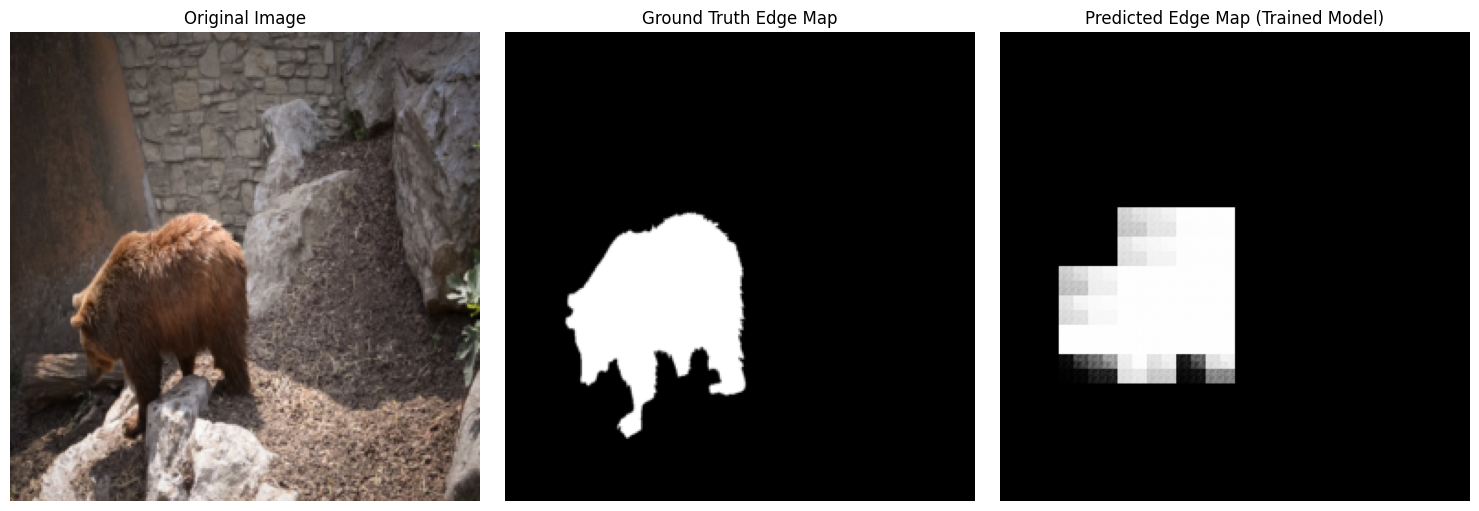

In [ ]:
# we pick a new video
video_name3_test, video_path3_test, annotation_path3_test = pick_video(name="bear")
dataset3_test = DAVISDataset(image_dir = video_path3_test, mask_dir = annotation_path3_test, transform = resize_normalize)

# plot a single frame
model3.eval();
with torch.no_grad():
    # random integer between min and max arg
    N = random.randint(0, len(dataset3_test)-1)
    test_image, test_mask = dataset3_test[N]  # Pick a random test frame
    test_image = test_image.unsqueeze(0)  # Add batch dimension
    pred_mask = model3(test_image)  # Predict edge mask

    side_comparison(test_image[0], test_mask.unsqueeze(0), normalize_min_max(pred_mask[0]).unsqueeze(0))

# Task 4: learnable pooling substitution

**Instructions:** As can be noticed, in the `ResNet` architecture there is a MaxPool(x) layer. Define a function F as a mini-network (with weights W), such that for some W, the function F_{W}(x) is identical with MaxPool(x). The mini-network F must be composed of only convolutional layers and pointwise nonlinearities (such as `ReLu`, `abs()`, etc., operating pointwise). Replace the MaxPool(x) function in the neural network with F and initialize it with W . Train on the frames of the chosen video, and show the results.

## Create and train `F_W`

Implement `F_W` as a learnable small CNN
which can approximate MaxPooling(x).
Ensure it only contains convolution layers and pointwise nonlinearities.

In [ ]:
class LearnablePooling(nn.Module):
    def __init__(self, in_channels):
        super(LearnablePooling, self).__init__()

        # setting K=4,S=2,P=1,K=4,S=2,P=1 ensures exact halving
        self.conv1 = nn.Conv2d(in_channels, in_channels, kernel_size=4, stride=2,
                               padding=1,groups=in_channels, bias=False)
        self.conv2 = nn.Conv2d(in_channels, in_channels , kernel_size=1, stride=1, bias=False)
        self.conv3 = nn.Conv2d(in_channels , in_channels, kernel_size=1, stride=1, bias=False)

        self.non_linearity1 = nn.ReLU()
        self.non_linearity2 = nn.ReLU()  # Add another ReLU
        self.non_linearity3 = nn.Sigmoid()  # New activation to introduce non-linearity

    def forward(self, x):
        x = self.conv1(x)
        x = self.non_linearity1(x)
        x = self.conv2(x)
        x = self.non_linearity2(x)
        x = self.conv3(x)
        x = self.non_linearity3(x)  # Apply sigmoid to bound values between 0-1

        return x


Next, we create an instance of this simple architecture so that it approximates MaxPooling.

For that purpose, we use random tensors and compare the model's outputs to that of MaxPool.

Epoch [1000/5000], Loss: 0.494398
Epoch [2000/5000], Loss: 0.493410
Epoch [3000/5000], Loss: 0.490626
Epoch [4000/5000], Loss: 0.491695
Epoch [5000/5000], Loss: 0.493797


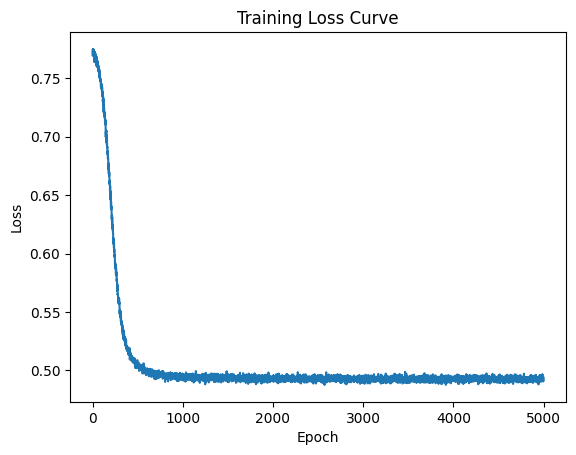

In [ ]:
# Initialize Model(s)
in_channels = 64  # for compatibility with Resnet18 layers
F_W = LearnablePooling(in_channels)
max_pool = nn.MaxPool2d(kernel_size=2, stride=2)  # Standard MaxPooling

# parameters used for training
num_epochs = 5000
learning_rate = 0.0001
optimizer = optim.Adam(F_W.parameters(), lr=learning_rate)
loss_fn = nn.MSELoss()  # Mean Squared Error between LearnablePooling & MaxPool
losses = []

F_W.train()  # Set the model to training mode

for epoch in range(num_epochs):
    # Generate a random input tensor of shape [8,64,32,32]
    # (batch_size=8 (or 12), 64 channels, 32x32 size)
    x = torch.randn(12, in_channels, 32, 32)
    epoch_loss = 0.0

    # Compute outputs
    with torch.no_grad():
        y_true = max_pool(x)  # Ground truth from MaxPooling

    y_pred = F_W(x)  # Our model's prediction

    # Compute Loss
    loss = loss_fn(y_pred, y_true)

    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    epoch_loss += loss.item()
    losses.append(epoch_loss)

    # Print progress
    if (epoch + 1) % 1000 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.6f}")

plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.show()

# SAVE THE MODEL AFTER TRAINING
torch.save(F_W.state_dict(), save_path + '/learnable_pool.pth')

## Implement the `ResNet18` Encoder with `F_W` replacing `MaxPool`



In [ ]:
class Encoder4(nn.Module):
    def __init__(self, pretrained=True, learnable_pool=None):
        super(Encoder4, self).__init__()

        resnet = models.resnet18(pretrained=pretrained)

        # Replace the first maxpool layer with learnable_pool (F_W)
        self.learnable_pool = learnable_pool if learnable_pool is not None else LearnablePooling(in_channels=64)

        # Extract early ResNet layers
        self.encoder = nn.Sequential(*list(resnet.children())[:4])  # Extract early ResNet layers

        # Replace MaxPool here (nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
        self.encoder[3] = self.learnable_pool

        # Keep the rest of ResNet (including fc)
        self.rest_of_resnet = nn.Sequential(*list(resnet.children())[4:])

    def forward(self, x):
        x = self.encoder(x)  # Pass through first layers (including learnable_pooling)
        for i, layer in enumerate(self.rest_of_resnet[:-1]): # Apply all layers *except* fc
            x = layer(x)
        return x

# test
encoder4_dummy= Encoder4()
summary(encoder4_dummy, input_size=(1, 3, 256, 256))

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Layer (type:depth-idx)                        Output Shape              Param #
Encoder4                                      [1, 512, 1, 1]            --
├─Sequential: 1-1                             [1, 64, 64, 64]           --
│    └─Conv2d: 2-1                            [1, 64, 128, 128]         9,408
│    └─BatchNorm2d: 2-2                       [1, 64, 128, 128]         128
│    └─ReLU: 2-3                              [1, 64, 128, 128]         --
│    └─LearnablePooling: 2-4                  [1, 64, 64, 64]           --
│    │    └─Conv2d: 3-1                       [1, 64, 64, 64]           1,024
│    │    └─ReLU: 3-2                         [1, 64, 64, 64]           --
│    │    └─Conv2d: 3-3                       [1, 64, 64, 64]           4,096
│    │    └─ReLU: 3-4                         [1, 64, 64, 64]           --
│    │    └─Conv2d: 3-5                       [1, 64, 64, 64]           4,096
│    │    └─Sigmoid: 3-6                      [1, 64, 64, 64]           --
├─Seque

## Implement `EdgeDetectionModel4`


First define `Decoder4` for integration with `Encoder4` and implement `EdgeDetectionModel`

In [ ]:
class Decoder4(nn.Module):
    def __init__(self, num_classes=1):
        super(Decoder4, self).__init__()

        # Adjust kernel_size, stride, and padding to output 256x256
        self.up1 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.up3 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.up4 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.up5 = nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2)
        self.up6 = nn.ConvTranspose2d(16, num_classes, kernel_size=2, stride=2)
        self.up7 = nn.ConvTranspose2d(num_classes, num_classes, kernel_size=2, stride=2) # 64x64 -> 128x128
        self.up8 = nn.ConvTranspose2d(num_classes, num_classes, kernel_size=2, stride=2) # 128x128 -> 256x256


    def forward(self, x):
        x = self.up1(x)  # output size: (512, 16, 16) → (256, 32, 32)
        x = self.up2(x)  # output size: (256, 32, 32) → (128, 64, 64)
        x = self.up3(x)  # output size: (128, 64, 64) → (64, 128, 128)
        x = self.up4(x)  # output size: (64, 128, 128) → (32, 256, 256)
        x = self.up5(x)
        x = self.up6(x)
        x = self.up7(x)
        x = self.up8(x)
        return x


# We implement our new edge detection model combining `Encoder4` encoder with `Decoder4`
class EdgeDetectionModel4(nn.Module):
    def __init__(self, pretrained=True, learnable_pool=None):
        super(EdgeDetectionModel4, self).__init__()

        # Use modified ResNet with LearnablePooling (Encoder4)
        self.encoder = Encoder4(pretrained=pretrained, learnable_pool=learnable_pool)

        # Use the (hand-crafted) 'Decoder4' decoder
        self.decoder = Decoder4()  # Output: single-channel edge map

    def forward(self, x):
        features = self.encoder(x)  # ResNet encoder extracts deep features
        edges = self.decoder(features)  # Decoder upsamples to match ground truth
        return edges

# test: visualize layers
model_dummy= EdgeDetectionModel4(pretrained=False, learnable_pool=None)
summary(model_dummy, input_size=(1, 3, 256, 256))

Layer (type:depth-idx)                             Output Shape              Param #
EdgeDetectionModel4                                [1, 1, 256, 256]          --
├─Encoder4: 1-1                                    [1, 512, 1, 1]            --
│    └─Sequential: 2-1                             [1, 64, 64, 64]           --
│    │    └─Conv2d: 3-1                            [1, 64, 128, 128]         9,408
│    │    └─BatchNorm2d: 3-2                       [1, 64, 128, 128]         128
│    │    └─ReLU: 3-3                              [1, 64, 128, 128]         --
│    │    └─LearnablePooling: 3-4                  [1, 64, 64, 64]           9,216
│    └─Sequential: 2-2                             --                        513,000
│    │    └─Sequential: 3-5                        [1, 64, 64, 64]           147,968
│    │    └─Sequential: 3-6                        [1, 128, 32, 32]          525,568
│    │    └─Sequential: 3-7                        [1, 256, 16, 16]          2,099,712
│    │

Initialize and train `model4` as instance of this new architecture

<ipython-input-52-c51d3da837ed>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  F_W.load_state_dict(torch.load(save_path + '/learnable_pool.pth'))
/usr/local/lib/python3.11

Epoch 2/20, Loss: 0.4131
Epoch 4/20, Loss: 0.1353
Epoch 6/20, Loss: 0.1041
Epoch 8/20, Loss: 0.0868
Epoch 10/20, Loss: 0.0780
Epoch 12/20, Loss: 0.0669
Epoch 14/20, Loss: 0.0639
Epoch 16/20, Loss: 0.0566
Epoch 18/20, Loss: 0.0563
Epoch 20/20, Loss: 0.0518


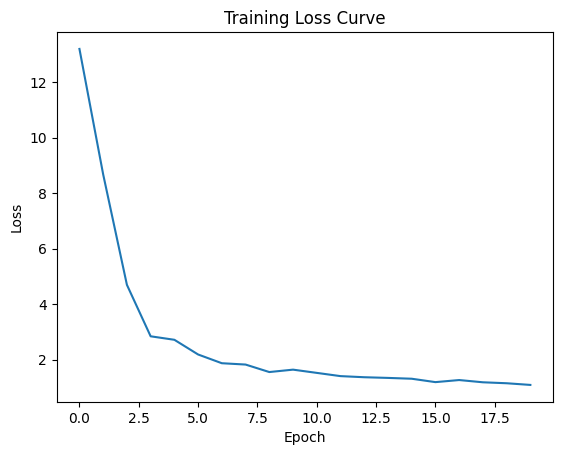

In [ ]:
# load learnable pooling
F_W = LearnablePooling(in_channels=64)
F_W.load_state_dict(torch.load(save_path + '/learnable_pool.pth'))

# Initialize model4 with F_W as learnable_pool kwarg
model4 = EdgeDetectionModel4(pretrained=False, learnable_pool=F_W)

# parameters for training
dataset4 = dataset3
learning_rate = 0.001
loss4 = nn.BCEWithLogitsLoss()  # Edge detection loss
num_epochs = 20
batch_size = 4

# train the model
train_model(model4, dataset=dataset4, batch_size=batch_size, loss=loss4, epochs=num_epochs)

# SAVE MODEL4 AFTER TRAINING
torch.save(model4.state_dict(), save_path + '/model4.pth')

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
<ipython-input-50-d163453a7136>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more detail

Epoch 1/10, Loss: 0.0584
Epoch 2/10, Loss: 0.0572
Epoch 3/10, Loss: 0.0578
Epoch 4/10, Loss: 0.0571
Epoch 5/10, Loss: 0.0574
Epoch 6/10, Loss: 0.0569
Epoch 7/10, Loss: 0.0561
Epoch 8/10, Loss: 0.0561
Epoch 9/10, Loss: 0.0564
Epoch 10/10, Loss: 0.0573


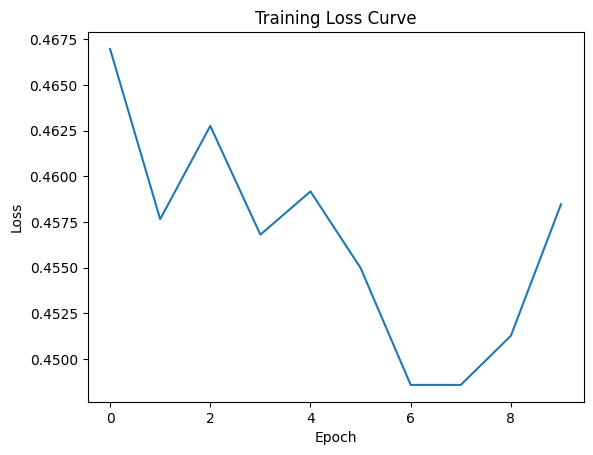


 Achieved re-training over 10


In [ ]:
# RE-RERUN TO ACHIEVE BETTER RESULTS
# load model
model4 = EdgeDetectionModel4(pretrained=False, learnable_pool=F_W)
model4.load_state_dict(torch.load(save_path + '/model4.pth'))

# hyperparameters
epochs=10
lr=0.00001
batch_size=11

train_model(model4, dataset=dataset4, batch_size=batch_size, loss=loss4, epochs=epochs, lr=lr)

print(f"\n Achieved re-training over {epochs}")

# save
torch.save(model4.state_dict(), save_path + '/model4.pth')

## Show the results

The newly chosen video is: bear


<ipython-input-51-8c9a807c853e>:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model4.load_state_dict(torch.load(save_path + '/model4.pth'))


Tensor Shape: torch.Size([1, 3, 256, 256])
Mean: 0.35180869698524475
Std: 0.17011883854866028
Min: 0.0
Max: 1.0
---------------------------------------------------------------------------
Tensor Shape: torch.Size([1, 1, 256, 256])
Mean: 0.12004249542951584
Std: 0.32151439785957336
Min: 0.0
Max: 1.0
---------------------------------------------------------------------------
Tensor Shape: torch.Size([1, 1, 256, 256])
Mean: 0.827625572681427
Std: 0.0999654084444046
Min: 0.0
Max: 1.0
---------------------------------------------------------------------------


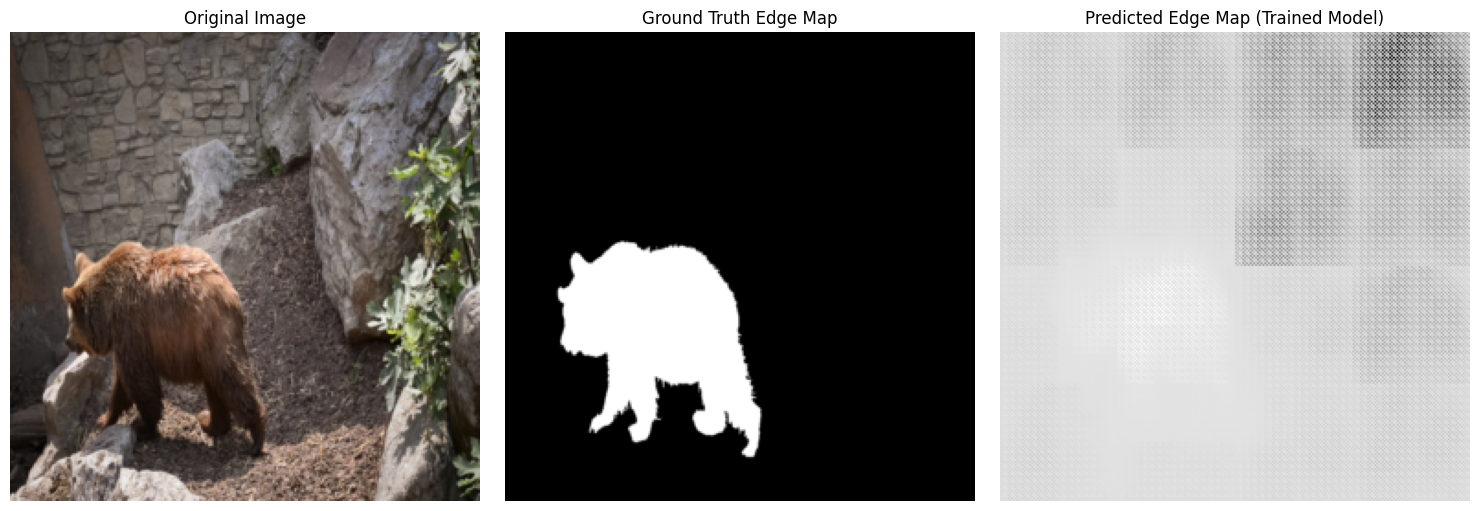

In [ ]:
# Define test video path and test dataset
video_name_test = "bear"
_, video_path_test, annotation_path_test = pick_video(name=video_name_test)
dataset_test = DAVISDataset(image_dir = video_path_test, mask_dir = annotation_path_test, transform = resize_normalize)

# Create DataLoader
dataloader_test = DataLoader(dataset_test, batch_size=1, shuffle=False)

# LOAD 'model4'
model4 = EdgeDetectionModel4(pretrained=True, learnable_pool=F_W)
model4.load_state_dict(torch.load(save_path + '/model4.pth'))
model4.eval()  # Switch to evaluation mode

with torch.no_grad():
    sample_img, sample_mask = next(iter(dataloader_test))
    pred_mask = model4(sample_img)  # Model prediction

tensor_describe(sample_img)
tensor_describe(sample_mask)
tensor_describe(normalize_min_max(pred_mask))

side_comparison(sample_img, sample_mask, normalize_min_max(pred_mask))

# Task 5: Build and train a network that will take into account the consecutive frame connections.

## **5.a)-b)** Building the temporal Encoder-Decoder

**Instructions:**

**5.a)** Build an Encoder-Decoder architecture network 𝑁𝑁() that takes the concatenation of the current frame and the output of the previous frame as an input.
More precisely, let 𝐹1, ..., 𝐹𝑇 ∈ 𝑅^{1×3×𝐻×𝑊} be the frames of the chosen video, 𝑁𝑁() be the neural network we want to build, and 𝑂𝑢𝑡_0, 𝑂𝑢𝑡_1, ..., 𝑂𝑢𝑡_𝑇 are defined in the following way: 𝑂𝑢𝑡_0 ∈ 𝑅^{1×1×𝐻×𝑊} is a tensor filled with zeros, while  𝑂𝑢𝑡_𝑡 = 𝑁𝑁(𝐹𝑡||𝑂𝑢𝑡𝑡_1) for every 𝑡 = 1, 2, ..., 𝑇, where by || we denote the concatenation operation of tensors along the channel axis.

**5.b)** Take as the encoder of the above-mentioned neural network 𝑁𝑁() the same architecture as in step 2. (**except for the first convolution layer, which will accept 4-channeled input instead of 3-channeled**). Initialize the encoder with the pre-trained ResNet weights except for the kernel of the first convolution. For the kernel of the first convolution make the following initialization: the kernel is a tensor with the shape (𝐻, 𝑊, 4, 𝑂𝑢𝑡𝐶ℎ𝑎𝑛𝑛𝑒𝑙𝑠), initialize its slice [:,:,:3,:] with the pre-trained ResNet’s first convolution kernel, and the slice [:,:,3,:] with zeros.

### Implement `NN()`

Building the Network:
define the modified Encoder-Decoder network with a 4-channel input

In [ ]:
class Decoder5(nn.Module):
    def __init__(self, num_classes=1):
        super(Decoder5, self).__init__()

        # Adjust kernel_size, stride, and padding to output 256x256
        self.up1 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.up3 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.up4 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.up5 = nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2)
        self.final_conv = nn.Conv2d(16, num_classes, kernel_size=1) # output to 1 channel

    def forward(self, x):
        x = self.up1(x)  # output size: (512, 16, 16) → (256, 32, 32)
        x = self.up2(x)  # output size: (256, 32, 32) → (128, 64, 64)
        x = self.up3(x)  # output size: (128, 64, 64) → (64, 128, 128)
        x = self.up4(x)  # output size: (64, 128, 128) → (32, 256, 256)
        x = self.up5(x) # output size: (32, 256, 256) → (16, 512, 512)
        x = F.interpolate(x, size=(256, 256), mode='bilinear', align_corners=False) # output size: (16, 512, 512) → (16, 256, 256)
        x = self.final_conv(x)  # output size: (16, 256, 256) → (1, 256, 256)
        x = torch.sigmoid(x)  # Apply sigmoid to bound values between 0-1
        return x


# CREATE CLASS NN
class NN(nn.Module):
    """
    Encoder-Decoder model using ResNet18 as the backbone.
    The first convolution layer is modified to accept 4 channels (RGB + previous output).
    """
    def __init__(self, pretrained=True):
        super(NN, self).__init__()

        # Load ResNet18 as encoder
        resnet = models.resnet18(pretrained=pretrained)

        # Modify first convolution layer to accept 4 channels
        old_conv = resnet.conv1
        new_conv = nn.Conv2d(4, old_conv.out_channels, kernel_size=old_conv.kernel_size,
                             stride=old_conv.stride, padding=old_conv.padding, bias=False)

        # Initialize first 3 channels with pretrained weights, last channel with zeros
        new_conv.weight.data[:, :3, :, :] = old_conv.weight.data
        new_conv.weight.data[:, 3, :, :] = 0
        resnet.conv1 = new_conv


        self.encoder = nn.Sequential(*list(resnet.children())[:-2])

        self.decoder = Decoder5()


    def forward(self, x):
        """
        x: concatenation of RGB/L frames along channel axis,
        shape (B, 3+1, H, W)
        """
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# visualize info
model_dummy= NN(pretrained=False)
summary(model_dummy, input_size=(1,4, 256, 256))

Layer (type:depth-idx)                        Output Shape              Param #
NN                                            [1, 1, 256, 256]          --
├─Sequential: 1-1                             [1, 512, 8, 8]            --
│    └─Conv2d: 2-1                            [1, 64, 128, 128]         12,544
│    └─BatchNorm2d: 2-2                       [1, 64, 128, 128]         128
│    └─ReLU: 2-3                              [1, 64, 128, 128]         --
│    └─MaxPool2d: 2-4                         [1, 64, 64, 64]           --
│    └─Sequential: 2-5                        [1, 64, 64, 64]           --
│    │    └─BasicBlock: 3-1                   [1, 64, 64, 64]           73,984
│    │    └─BasicBlock: 3-2                   [1, 64, 64, 64]           73,984
│    └─Sequential: 2-6                        [1, 128, 32, 32]          --
│    │    └─BasicBlock: 3-3                   [1, 128, 32, 32]          230,144
│    │    └─BasicBlock: 3-4                   [1, 128, 32, 32]          295,4

## 5 c) Training the temporal Encoder-Decoder

**Instructions:** Train the network 𝑁𝑁() obtained in step 5.a)-b) on the *k*-**length frame sequences** from the chosen video (try to overfit on the chosen video). The *k*-length frame sequences should be subvideos of the initial video consisting of consecutive frames. The hyperparameter *k* can be chosen arbitrarily by the candidate but it should be greater than 1. Show the training results.

**Rem:**
- we choose k=2 for simplicity;
- the induction relation has the form
h_t = NN(x_t||h_{t-1})
which defines a Recurrent Convolutional Neural Network (ConvRNN).

In [ ]:
class ConvRNN(nn.Module):
    def __init__(self, hidden_channels=1, rnn_nn=None):
        super(ConvRNN, self).__init__()
        self.hidden_channels = hidden_channels
        self.nn = rnn_nn  # Use provided CNN model (assumed to take 4 channels)

    def forward(self, x_t, h_t_prev):
        combined = torch.cat([x_t, h_t_prev], dim=1)  # Always has 4 channels
        h_t = self.nn(combined)  # Apply CNN transformation
        return h_t


### Implement new data loader

In [ ]:
class ConvRNNDataset(Dataset):
    """
    Custom PyTorch Dataset for training the ConvRNN model.
    This dataset provides sequences of video frames and their corresponding edge masks.

    Attributes:
    - frame_dir: Path to video frames.
    - mask_dir: Path to edge masks.
    - transform: Transformations for both frames & masks.
    """

    def __init__(self, frame_dir, mask_dir, transform=None):
        self.frame_dir = frame_dir  # Path to frames
        self.mask_dir = mask_dir    # Path to edge masks
        self.transform = transform  # Transformations applied to both

        # List all frame filenames (assume they match between frames & masks)
        self.frame_filenames = sorted(os.listdir(frame_dir))

    def __len__(self):
        return len(self.frame_filenames) - 1  # Because we need (x_t, h_t_prev) pairs

    def __getitem__(self, idx):
        """
        Returns a tuple: (x_t, h_t_prev, target)
        - x_t: Current frame (RGB)
        - h_t_prev: Previous output frame (grayscale)
        - target: Ground truth edge mask (grayscale)
        """
        frame_name = self.frame_filenames[idx]
        prev_frame_name = self.frame_filenames[max(0, idx - 1)]  # Ensure idx-1 is valid

        # Load current frame x_t
        x_t_path = os.path.join(self.frame_dir, frame_name)
        x_t = Image.open(x_t_path).convert("RGB")  # RGB image

        # Load previous frame h_t_prev
        h_t_prev_path = os.path.join(self.frame_dir, prev_frame_name)
        h_t_prev = Image.open(h_t_prev_path).convert("L")  # Convert to grayscale

        # Load corresponding mask (target)
        mask_path = os.path.join(self.mask_dir, frame_name.replace(".jpg", ".png"))  # Assuming PNG masks
        target = Image.open(mask_path).convert("L")  # Convert to grayscale

        # Apply transformations if specified
        if self.transform:
            x_t = self.transform(x_t)
            h_t_prev = self.transform(h_t_prev)
            target = self.transform(target)

        # Convert grayscale h_t_prev to single-channel tensor
        h_t_prev = h_t_prev  # Ensure correct shape [B,1, H, W]

        return x_t, h_t_prev, target  # Matches training loop expectations


Pick the 'soapbox' video and set hyperparameters for ConvRNN.

In [ ]:
video_name5, video_path5, annotation_path5 = pick_video(name="soapbox")
frames = sorted(os.listdir(video_path5))
dataset5 = ConvRNNDataset(frame_dir=video_path5, mask_dir=annotation_path5, transform=resize_normalize)

# hyperparameters
input_size = 3  # Number of channels in x_t (RGB)
# k=2  # ==Number of frames in training sequences
hidden_size = 1  # Number of channels in hidden state h_t
learning_rate = 0.001
batch_size = 8
num_epochs = 5


#Create the Dataloader
dataloader5 = DataLoader(dataset5, batch_size=batch_size, shuffle=True)
# prints a few outputs
x_t, h_t_prev, target = next(iter(dataloader5))
print(f"x_t shape: {x_t.shape}")
print(f"h_t_prev shape: {h_t_prev.shape}")
print(f"target shape: {target.shape}")

The newly chosen video is: soapbox


### Training loop

Epoch [1/5], Loss: 0.4591
Epoch [2/5], Loss: 0.1365
Epoch [3/5], Loss: 0.1204
Epoch [4/5], Loss: 0.1135
Epoch [5/5], Loss: 0.1103


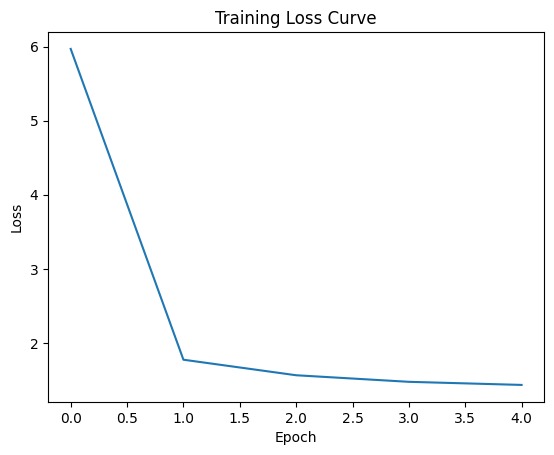

In [ ]:
model5 = ConvRNN(hidden_channels=hidden_size, rnn_nn=NN())

criterion = nn.BCELoss()  # Binary Cross Entropy, suitable for edge detection
optimizer = optim.Adam(model5.parameters(), lr=learning_rate)

# Training loop
num_epochs = 5
losses =[]

for epoch in range(num_epochs):
    epoch_loss = 0.0  # Track loss for averaging

    for x_t, h_t_prev, target in dataloader5:  # Assume this gives (batch_size=8, C, H, W) tensors
        optimizer.zero_grad()  # Reset gradients

        # Forward pass
        h_t = model5(x_t, h_t_prev)

        # Compute loss
        loss = criterion(h_t, target)

        # Backpropagation
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    losses.append(epoch_loss)

    # Print epoch loss
    avg_loss = epoch_loss / len(dataloader5)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.show()

# SAVE THE MODEL AFTER TRAINING
torch.save(model5.state_dict(), save_path + '/model5.pth')

# Task 6: Perceptual Losses

**Instructions:**
Add perceptual losses to the training and train with the new loss. Show the training results and compare them with the previous results.

## Setting `PerceptualLoss` class

We use the VGG16 pre-trained network to extract features at an intermediate layer (8).

In [ ]:
class PerceptualLoss(nn.Module):
    def __init__(self, layer=8, weight=0.1):  # layer=8 corresponds to early features
        super(PerceptualLoss, self).__init__()
        vgg = models.vgg16(pretrained=True).features  # Load VGG16 features
        self.feature_extractor = nn.Sequential(*list(vgg.children())[:layer]).eval()  # Extract up to a certain layer
        for param in self.feature_extractor.parameters():
            param.requires_grad = False  # Freeze VGG weights

        self.weight = weight  # Weight for perceptual loss component

    def forward(self, prediction, target):
        pred_features = self.feature_extractor(prediction)  # Extract features
        target_features = self.feature_extractor(target)  # Extract target features
        perceptual_loss = F.mse_loss(pred_features, target_features)  # Compare features
        return perceptual_loss * self.weight  # Scale perceptual loss

## Training loop

Epoch [1/5], BCE Loss: 0.1862, Perceptual Loss: 0.1683, Epoch Loss: 0.6210
Epoch [2/5], BCE Loss: 0.0614, Perceptual Loss: 0.0894, Epoch Loss: 0.2936
Epoch [3/5], BCE Loss: 0.0592, Perceptual Loss: 0.0772, Epoch Loss: 0.2791
Epoch [4/5], BCE Loss: 0.1900, Perceptual Loss: 0.2419, Epoch Loss: 0.2852
Epoch [5/5], BCE Loss: 0.1619, Perceptual Loss: 0.2120, Epoch Loss: 0.2722


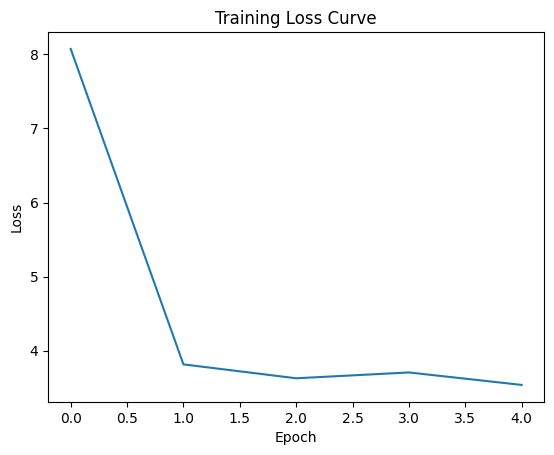

In [ ]:
# Initialize Model, Losses, and Optimizer
model6 = ConvRNN(hidden_channels=1, rnn_nn=NN())  # NN() is the provided convolutional model
bce_loss = nn.BCELoss()  # Binary Cross-Entropy for pixel-wise comparison
perceptual_loss = PerceptualLoss(layer=8, weight=0.1)  # Initialize perceptual loss
optimizer = optim.Adam(model6.parameters(), lr=0.001) # changed from model to model6

# Training Loop with Perceptual Loss
num_epochs = 5
losses = []

for epoch in range(num_epochs):
    epoch_loss = 0.0  # Track total loss

    for x_t, h_t_prev, target in dataloader5:
        optimizer.zero_grad()  # Reset gradients

        # Forward pass
        h_t = model6(x_t, h_t_prev) # changed from model to model6

        # Compute BCE Loss
        loss_bce = bce_loss(h_t, target)

        # Duplicate the channels of h_t and target to 3 channels
        h_t_3_channels = h_t.repeat(1, 3, 1, 1)
        target_3_channels = target.repeat(1, 3, 1, 1)

        # Compute Perceptual Loss
        loss_perceptual = perceptual_loss(h_t_3_channels, target_3_channels)

        # Total loss: BCE + Perceptual
        loss = loss_bce + loss_perceptual

        # Backpropagation
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    losses.append(epoch_loss)

    # Print epoch loss
    avg_loss = epoch_loss / len(dataloader5)
    print(f"Epoch [{epoch+1}/{num_epochs}], BCE Loss: {loss_bce.item():.4f}, Perceptual Loss: {loss_perceptual.item():.4f}, Loss: {avg_loss:.4f}")

plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.show()

# save
torch.save(model6.state_dict(), save_path + '/model6.pth')

# Task 7: Adding differentiable NMS

**Instructions:**
Add non-maximum suppression (for edge detection) after the output of the network (for the training stage):

- The non-maximum suppression must be a part of
the main graph and not just a post-processing function (to be able to put loss after the non-maximum suppression operation and train the network with this op.). Please don't use built-in functions, write a differentiable non-maximum suppression algorithm from scratch.

- Train the network initialized from point 6 and show the training results.

## Implementing the differentiable NMS algorithm

In [ ]:
def differentiable_nms(edge_map):
    """
    Differentiable Non-Maximum Suppression (NMS) for edge detection.
    Input: edge_map: Tensor of shape (B, 1, H, W) containing edge strength.
    Output: Suppressed edge map of the same shape.
    """
    # Compute gradients in x and y direction
    Gx = F.conv2d(edge_map, torch.tensor([[[[-1, 0, 1],
                                            [-2, 0, 2],
                                            [-1, 0, 1]]]], dtype=edge_map.dtype, device=edge_map.device), padding=1)
    Gy = F.conv2d(edge_map, torch.tensor([[[[-1, -2, -1],
                                            [ 0,  0,  0],
                                            [ 1,  2,  1]]]], dtype=edge_map.dtype, device=edge_map.device), padding=1)

    # Compute gradient magnitude and direction
    magnitude = torch.sqrt(Gx ** 2 + Gy ** 2 + 1e-6)  # Avoid zero division
    direction = torch.atan2(Gy, Gx)  # Gradient orientation

    # Quantize the gradient direction into 4 possible cases (0, 45, 90, 135 degrees)
    direction_quantized = torch.round((direction * (4 / torch.pi)) % 4)  # Normalize and map to [0, 1, 2, 3]

    # Shift tensors to compare neighbors in gradient direction
    def shift(tensor, dx, dy):
        # Pad the tensor with zeros to avoid boundary issues
        padded_tensor = F.pad(tensor, (max(0, dx), max(0, -dx), max(0, dy), max(0, -dy)))

        # Shift the tensor and crop to original size
        shifted_tensor = padded_tensor[:, :, max(0, -dy):padded_tensor.shape[2] + min(0, -dy), max(0, -dx):padded_tensor.shape[3] + min(0, -dx)]

        # Ensure the shifted tensor is the same size as the original tensor
        shifted_tensor = shifted_tensor[:, :, :tensor.shape[2], :tensor.shape[3]]

        return shifted_tensor

    # Get neighboring pixels along gradient direction
    offsets = {0: (1, 0), 1: (1, 1), 2: (0, 1), 3: (-1, 1)}  # Directions mapped to offsets
    dx1, dy1 = offsets[0][0], offsets[0][1]
    dx2, dy2 = -dx1, -dy1  # Opposite direction

    neighbor1 = shift(magnitude, dx1, dy1)
    neighbor2 = shift(magnitude, dx2, dy2)

    # Suppression via soft-max operation to keep differentiability
    suppression_mask = torch.sigmoid(10 * (magnitude - torch.max(neighbor1, neighbor2)))
    suppressed_edges = magnitude * suppression_mask

    return suppressed_edges


torch.Size([1, 1, 256, 256])
torch.Size([256, 256])
torch.Size([256, 256])


Text(0.5, 1.0, 'Suppressed Edge Map')

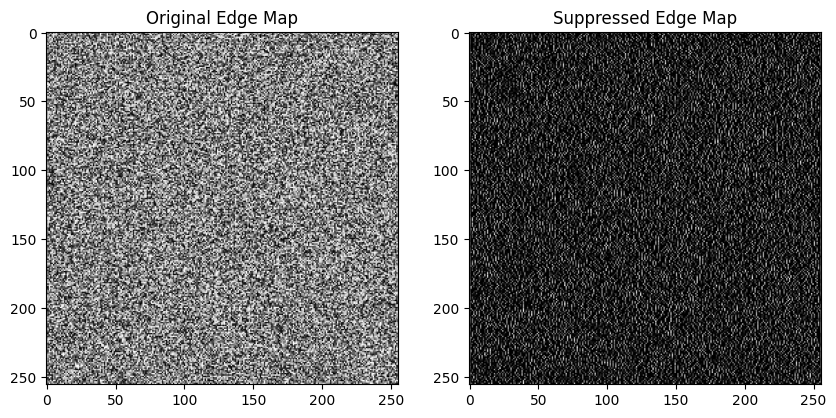

In [ ]:
# Example usage
edge_map = torch.rand(1, 1, 256, 256)  # Random edge map (batch size 1, single-channel, 256x256)
nms_output = differentiable_nms(edge_map)
print(nms_output.shape)  # Should match input shape

# squeeze edge_map and nms_output
edge_map = edge_map.squeeze()
nms_output = nms_output.squeeze()
print(edge_map.shape)
print(nms_output.shape)

# plot images
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(10,10))
axs[0].imshow(edge_map, cmap='gray')
axs[0].set_title('Original Edge Map')
axs[1].imshow(nms_output, cmap='gray')
axs[1].set_title('Suppressed Edge Map')

## Incorporate to main graph internally

We tweak the previous training loop (for task 6) to make sure NMS is incorporated in the model itself.

**Rem:** Altenatively, we could also move NMS directly into the forward pass within the class `ConvRNN` from Task 5 c).

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/5], BCE Loss: 0.9112, Perceptual Loss: 0.2055, Loss: 1.2660
Epoch [2/5], BCE Loss: 0.9839, Perceptual Loss: 0.2777, Loss: 1.2175
Epoch [3/5], BCE Loss: 0.9584, Perceptual Loss: 0.2495, Loss: 1.1902
Epoch [4/5], BCE Loss: 0.8896, Perceptual Loss: 0.1846, Loss: 1.1675
Epoch [5/5], BCE Loss: 1.0716, Perceptual Loss: 0.3009, Loss: 1.1739


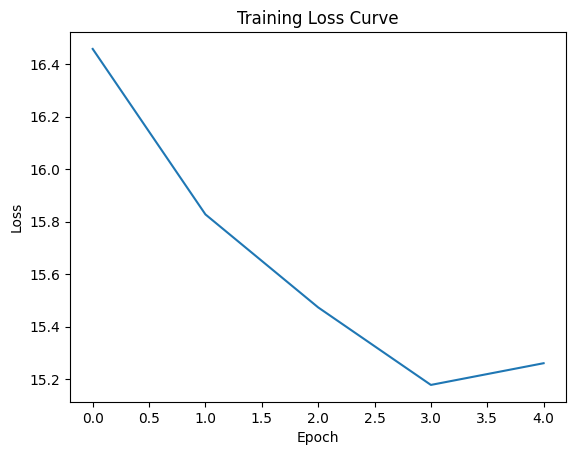

In [ ]:
# initialize model 7
model7 = ConvRNN(hidden_channels=1, rnn_nn=NN())

# Assuming 'bce_loss' and 'perceptual_loss' are already defined
bce_loss = torch.nn.BCELoss()  # Replace with your actual BCE loss
perceptual_loss = PerceptualLoss() # Replace with your actual Perceptual loss
optimizer = optim.Adam(model7.parameters(), lr=0.001)  # Assume you have an optimizer

# Training Loop with Differentiable NMS
num_epochs = 5
losses = []

for epoch in range(num_epochs):
    total_loss = 0.0  # Track total loss

    for x_t, h_t_prev, target in dataloader5:
        optimizer.zero_grad()  # Reset gradients

        # Forward pass
        h_t = model7(x_t, h_t_prev)  # Output edge map before NMS

        # Apply differentiable Non-Maximum Suppression (NMS)
        h_t_nms = differentiable_nms(h_t)  # Treat as blackbox

        # CLAMP OUTPUT OF differentiable_nms TO [0, 1]
        h_t_nms = torch.clamp(h_t_nms, 0, 1)

        # Compute BCE Loss AFTER NMS
        loss_bce = bce_loss(h_t_nms, target)

        # Repeat the edge map across 3 channels to make it compatible with VGG16
        h_t_nms_3ch = h_t_nms.repeat(1, 3, 1, 1)
        target_3ch = target.repeat(1, 3, 1, 1)

        # Compute Perceptual Loss AFTER NMS, using the 3-channel versions
        loss_perceptual = perceptual_loss(h_t_nms_3ch, target_3ch)

        # Total loss: BCE + Perceptual
        loss = loss_bce + loss_perceptual

        # Backpropagation
        loss.backward()
        optimizer.step()

        total_loss += loss.item()  # Accumulate total loss

    losses.append(total_loss)

    # Print epoch loss
    avg_loss = total_loss / len(dataloader5)
    print(f"Epoch [{epoch+1}/{num_epochs}], BCE Loss: {loss_bce.item():.4f}, Perceptual Loss: {loss_perceptual.item():.4f}, Loss: {avg_loss:.4f}")

plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.show()

# save model
torch.save(model7.state_dict(), save_path + '/model7.pth')